In [1]:
from PaulTrapAnalysis.functions.data import *
from PaulTrapAnalysis.functions.plotting import *
from PaulTrapAnalysis.functions.gradients import *
from PaulTrapAnalysis.functions.errors import *
from PaulTrapAnalysis.functions.potentials import *
from PaulTrapAnalysis.functions.fitting import *
from PaulTrapAnalysis.functions.equilibrium import *
import esim
from esim.utils import util
import xarray as xr
from scipy.optimize import leastsq, curve_fit
import PaulTrapAnalysis as PTA

>>> Using current directory!


## Potential Fitting

>>> Fitting using ROI only
>>> Using manual Harmonic Basis
>>> Using Least Square


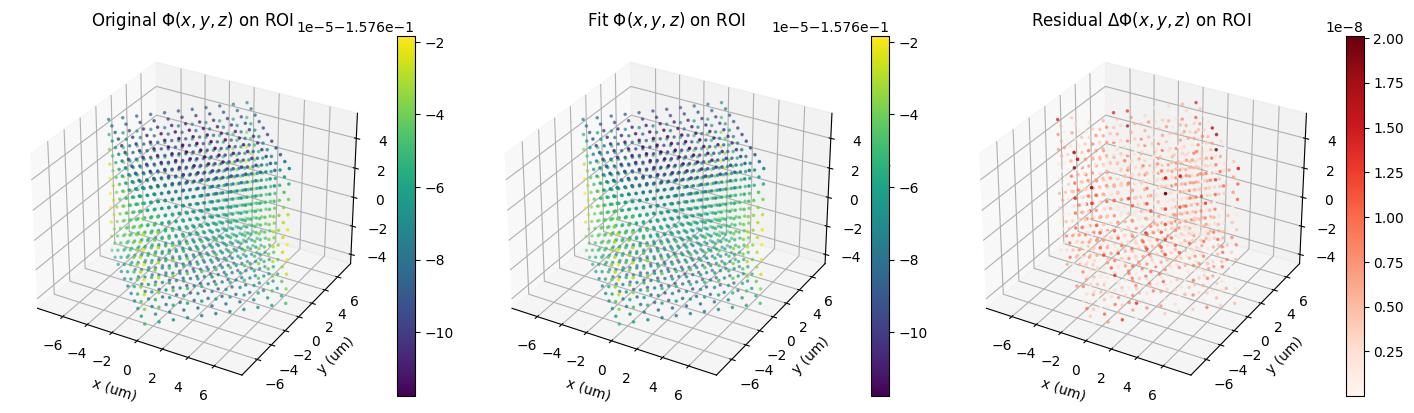

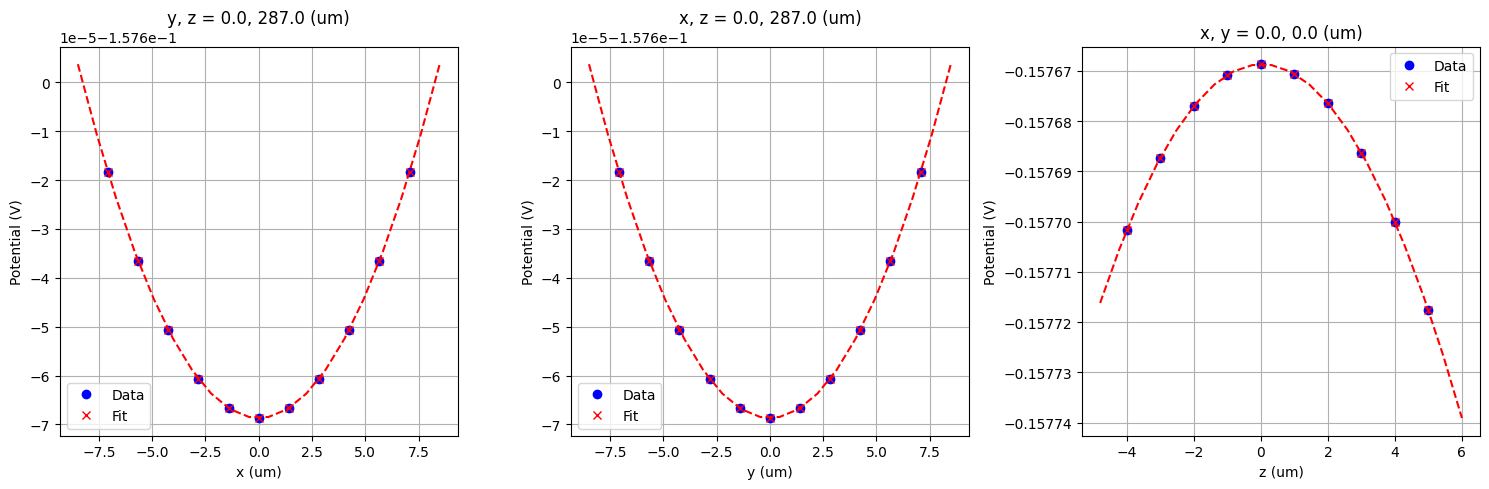

,Mj
C,-1.577e-01
Ey,-1.380e-07
Ez,1.010e-04
Ex,-5.080e-08
U3,1.140e-04
U4,2.061e-06
U2,-2.009e+00
U5,-2.116e-06
U1,1.856e-06
10,-8.157e-04


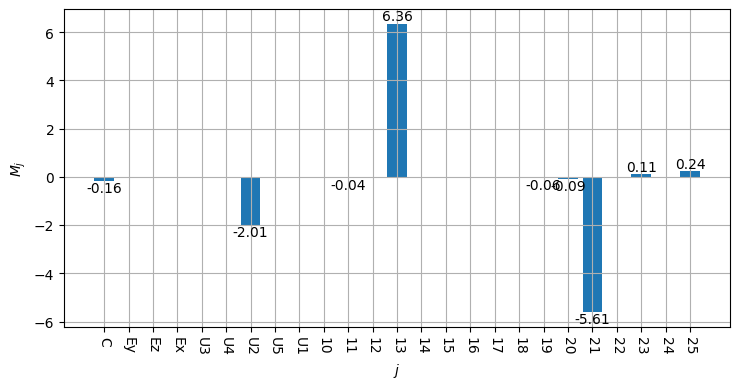

In [4]:
prefix = f'{PTA.data_dir}/Electron3dTrap_200um_v6_flipped/Electron3dTrap_200um_v6_flipped'
position = np.array([0,0,0.287]) # trap location, in mm unit
nROI = 0.005
s = get_electrodes(prefix, nROI, position, plot_multipoles=False)

config = dict(
    order = 4,
    scale = 1,
    unit = 1,
    r0 = position,
    electrode = 'DC',
    rotate=True,
    electrode_factors = np.array([-0.364604, -0.550222, -0.019522, -0.758919, 0.078677,
                          -0.548974, -0.034351, -0.759486, 0.082480]),
    fit_region = 'ROI',
    method = 'lstsq',
    n = 1,
    library = 'manual'
)
Mj_DC0, DC_err = fit_potential(s, **config)

>>> Fitting using ROI only
>>> Using manual Harmonic Basis
>>> Using Least Square


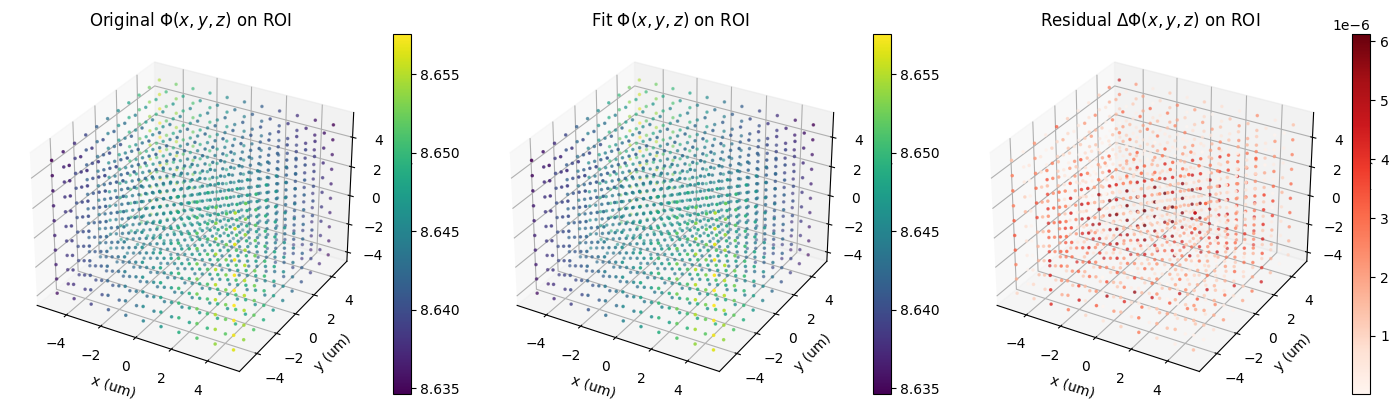

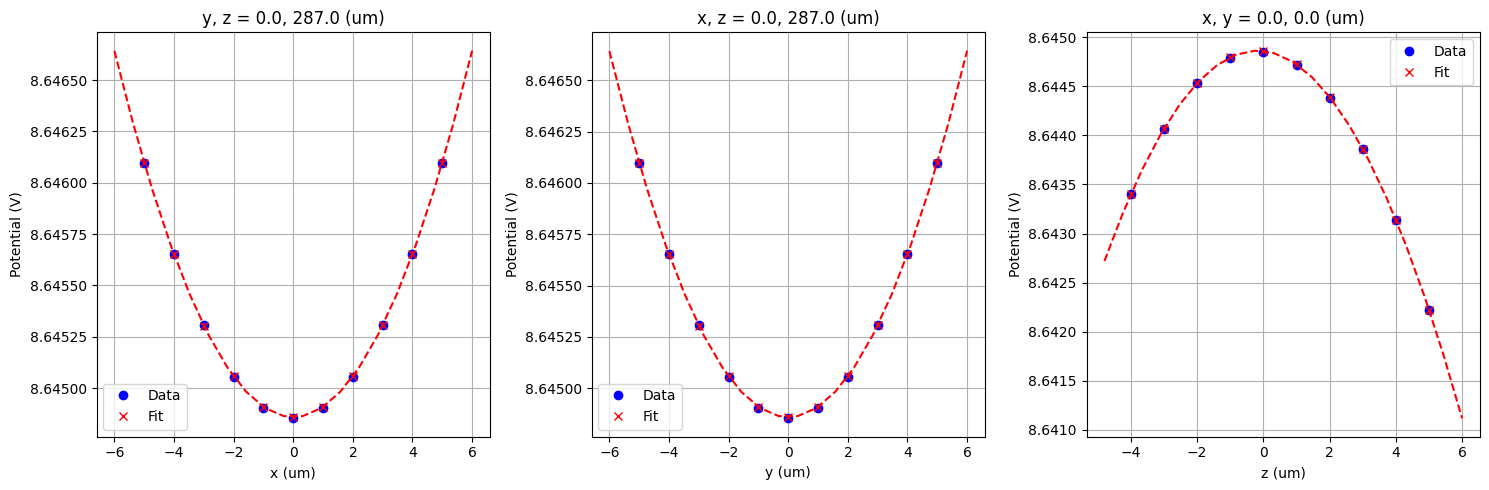

,Mj
C,8.645e+00
Ey,-1.404e-04
Ez,-3.667e-02
Ex,-8.113e-05
U3,-6.795e+01
U4,-2.099e-03
U2,-9.921e+01
U5,-1.126e-04
U1,-6.272e-03
10,2.647e-03


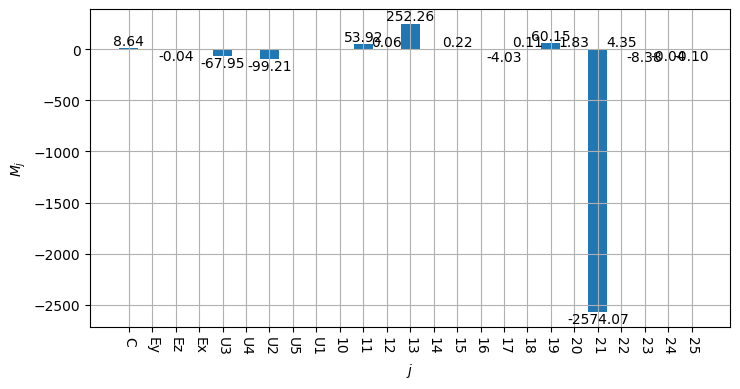

In [5]:
prefix = f'{PTA.data_dir}/Electron3dTrap_200um_v6_flipped/Electron3dTrap_200um_v6_flipped'
position = np.array([0,0,0.287]) # trap location, in mm unit
nROI = 0.005
s = get_electrodes(prefix, nROI, position, plot_multipoles=False)

config = dict(
    order = 4,
    scale = 1,
    unit = 1,
    r0 = position,
    electrode = 'RF',
    electrode_factors = [0, 35],
    fit_region = 'ROI',
    method = 'lstsq',
    n = 1,
    library = 'manual'
)
Mj_RF0, RF_err0 = fit_potential(s, **config)

In [6]:
scale, order = 1e3, 4
Mj_DC = rescale_Mj(Mj_DC0, scale, order).flatten()
Mj_RF = rescale_Mj(Mj_RF0, scale, order).flatten()

## Pseudo Potential

### Checking reconstructed pseudo potential

In [10]:
x, y, z = get_square()
rf_scale = get_rf_scale(l=1, o=2.5e9*2*np.pi)
phi_pseudo = get_pseudo_pot((x, y, z), Mj_RF[1:], rf_scale)

AttributeError: module 'PaulTrapAnalysis.functions.gradients' has no attribute 'dPhi_tf'

In [ ]:
plot_contour(phi_pseudo, x, y)

In [ ]:
x_slice = slice(s.origin[0] - s.roi[0], s.origin[0] + s.roi[0])
y_slice = slice(s.origin[1] - s.roi[1], s.origin[1] + s.roi[1])
z_slice = slice(s.origin[2] - s.roi[2], s.origin[2] + s.roi[2])
p = [35*s.trap.individual_potential_contribution(x = x_slice, y = y_slice, z = z_slice, derivative=i)['RF2'] for i in range(0,4)]

rf_scale_raw = get_rf_scale(l=1e-3, o=2.5e9*2*np.pi)
pseudo_pot_ori = rf_scale_raw**2 * np.array(xr.dot(p[1], p[1], dims = 'l'))

coord_roi = get_potential_data(s, electrode='RF')[0]
X_roi, Y_roi, Z_roi = coord_roi
x, y, z = get_grid(X_roi, Y_roi, Z_roi, position)
center = np.where(z==0)
x_roi = x[center]
y_roi = y[center]
pseudo_pot_center = pseudo_pot_ori.flatten()[center]

In [ ]:
def plot_contour(phi, x, y, scale=1e6, nspacing=1, colorbar_scale='log'):
    
    fig = plt.figure(figsize=(7.5,6))
    im = plt.scatter(x[::nspacing]*scale, y[::nspacing]*scale, c=phi[::nspacing], cmap='seismic', norm=colorbar_scale)
    fig.colorbar(im)
    plt.xlabel('x (um)')
    plt.ylabel('y (um)')
    plt.show()

In [ ]:
plot_contour(pseudo_pot_center, x_roi, y_roi, scale=1e3)

In [ ]:
x_rot, y_rot = rotate_45(x_roi, y_roi)
z_rot = np.zeros(np.shape(x_rot))

In [ ]:
phi_pseudo = get_pseudo_pot((x_rot/1e3, y_rot/1e3, z_rot), Mj_RF[1:], rf_scale)
plot_contour(phi_pseudo, x_roi, y_roi, scale=1e3)

In [ ]:
plot_contour(abs(phi_pseudo-pseudo_pot_center)/pseudo_pot_center*100, x_roi, y_roi, scale=1e3, colorbar_scale='log')

In [ ]:
percent_err = np.abs(phi_pseudo - pseudo_pot_center)/pseudo_pot_center*100
count, bins_count = np.histogram(percent_err, bins=1000, weights=np.ones(np.shape(percent_err))/len(percent_err))
cdf = np.cumsum(count)
plt.plot(bins_count[1:], cdf)
plt.title('Psudo Potential Reconstruction Error in ROI')
plt.xlabel('Relative Error (%)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.axvline(max(percent_err), linestyle='--', color='r', alpha=0.7)
plt.show()

### Test on 3-layer Potential

In [15]:
coord_roi = get_potential_data(s, electrode='RF')[0]
x, y, z = get_square(xlow=-50e-6,xhigh=50e-6,ylow=-50e-6,yhigh=50e-6,npoints=100)

In [16]:
Mj = util.load_data('spher_harm_coeff_3layer')
Mj_DC = Mj['DC']
Mj_RF = Mj['RF']
Mj_DC0 = Mj['DC0']
Mj_RF0 = Mj['RF0']

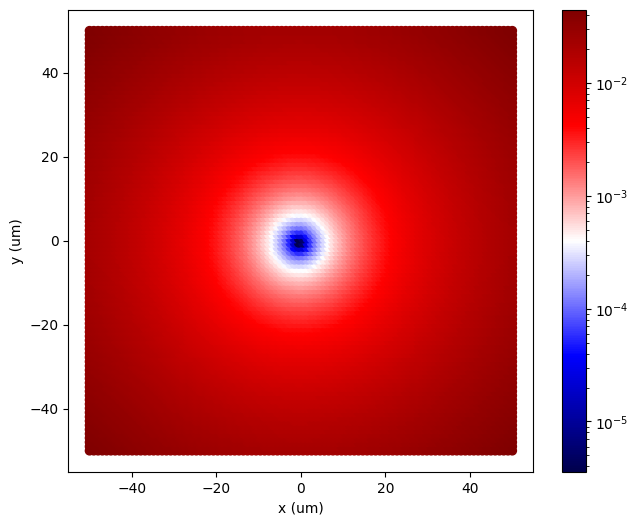

In [17]:
rf_scale = get_rf_scale(o=1.6e9*2*np.pi)
phi_pseudo = get_pseudo_pot((x, y, z), Mj_RF, rf_scale)
plot_contour(phi_pseudo, x, y)#, scale=1e3)

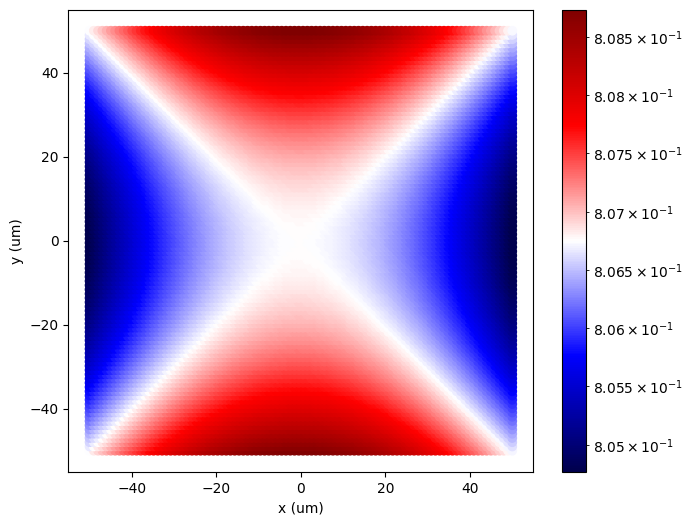

In [18]:
phi_rf = Phi((x,y,z), Mj_RF0)/90
plot_contour(phi_rf, x, y)#, scale=1e3)

In [19]:
EquilPos(1, Mj_DC, Mj_RF, o=2*np.pi*1.6e9)

array([[5.61984370e-07, 2.93688793e-08, 1.27063112e-06]])

In [20]:
EquilPos(2, Mj_DC, Mj_RF, o=2*np.pi*1.6e9)

array([[ 5.44524700e-07,  1.59334587e-08, -1.42761558e-05],
       [ 5.81061029e-07,  4.72557487e-08,  1.68266064e-05]])

In [21]:
12e-6+1.46e-6, -12e-6+1.46e-6

(1.346e-05, -1.054e-05)

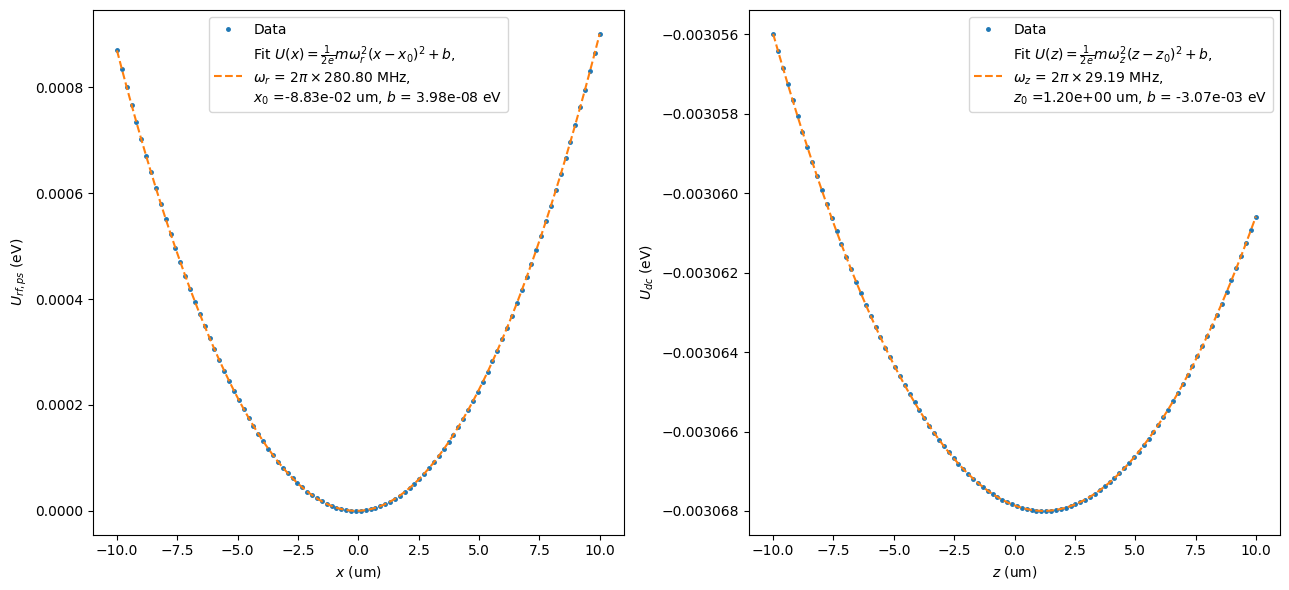

In [22]:
axis = [0,2]
ranges = [(-10e-6,10e-6)]*3
n_points = 100

rf_scale = get_rf_scale(o=1.6e9*2*np.pi)
#init = [300e6*2*np.pi, 0, 0]
fit_func = lambda x, omega, x0, b: 1/2/e*m*(omega**2) * (x-x0)**2 + b
#fit_func = lambda x, omega: 1/2/e*m*(omega**2) * (x)**2
freq = [2*np.pi*300e6, 2*np.pi*30e6]
xlabel = [r'$x$ (um)', r'$z$ (um)']
ylabel = [r'$U_{rf, ps}$ (eV)', r'$U_{dc}$ (eV)']
fig, ax = plt.subplots(figsize=(13,6), ncols=2)
for i in range(2):
    coord = np.zeros((3,n_points))
    xdata = coord[axis[i]] = np.linspace(*ranges[axis[i]],n_points)
    if i == 0:
        ydata = get_pseudo_pot(coord, Mj_RF, rf_scale)
    else:
        ydata = -Phi(coord, Mj_DC0)
    #ydata = get_pseudo_pot(coord, Mj_RF, rf_scale) - Phi(coord, Mj_DC0)
    ax[i].plot(xdata*1e6, ydata, '.', markersize=5, label='Data')
    init = [freq[i], 0, 0]
    c = curve_fit(fit_func, xdata, ydata, p0=init, xtol=1e-15, ftol=1e-30)[0]
    if i == 0:
        ax[i].plot(xdata*1e6, fit_func(xdata, *c), '--', 
                     label=r'Fit $U(x)=\frac{1}{2e} m\omega_r^2(x-x_0)^2 + b$,' + '\n' +\
                           r'$\omega_r$ = $2\pi\times$'+f'{c[0]/1e6/2/np.pi:.2f} MHz,' + '\n'+\
                           r'$x_0$' + f' ={c[1]*1e6:.2e} um'+ \
                           r', $b$' + f' = {c[2]:.2e} eV')
    else:
        ax[i].plot(xdata*1e6, fit_func(xdata, *c), '--', 
                     label=r'Fit $U(z)=\frac{1}{2e} m\omega_z^2(z-z_0)^2 + b$,' + '\n' +\
                           r'$\omega_z$ = $2\pi\times$'+f'{c[0]/1e6/2/np.pi:.2f} MHz,' +'\n'+\
                           r'$z_0$' + f' ={c[1]*1e6:.2e} um'+ \
                           r', $b$' + f' = {c[2]:.2e} eV')
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel(ylabel[i])
plt.tight_layout()
ax[0].legend()
ax[1].legend()
plt.show()

## Equilibrium Position

In [24]:
Mj = util.load_data('spher_harm_coeff')
Mj_DC = Mj['DC0'].flatten()
Mj_RF = Mj['RF0'].flatten()

In [25]:
EquilPos(1, Mj_DC[1:], Mj_RF[1:], o=2*np.pi*2.5e9)

array([[ 8.30985172e-11,  5.37898859e-10, -1.19199513e-07]])

In [26]:
EquilPos(2, Mj_DC[1:], Mj_RF[1:], o=2*np.pi*2.5e9)

array([[-4.50999563e-09,  7.32231104e-10, -3.15830257e-06],
       [ 4.09529742e-09,  1.17570900e-09,  3.70514419e-06]])

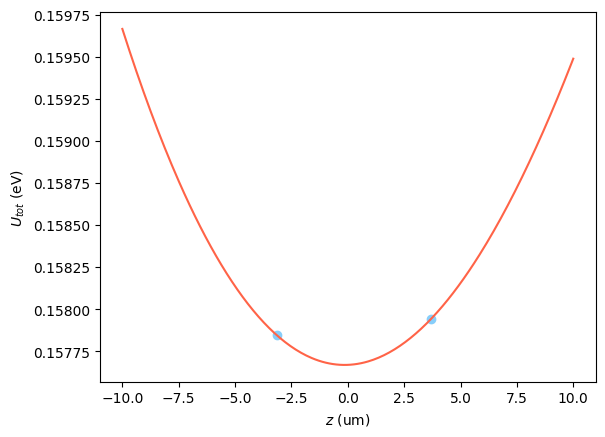

In [27]:
plt.figure()
zeta0 = np.expand_dims(EquilPos(2, Mj_DC[1:], Mj_RF[1:], o=2*np.pi*2.5e9)[:,-1], axis=1)
zetagrid = np.expand_dims(np.linspace(-10e-6,10e-6,256), axis=1)
shape = np.shape(zetagrid)
all_r = np.concatenate([np.zeros(shape), np.zeros(shape), zetagrid], axis=1)
shape_zeta = np.shape(zeta0)
all_r_zeta = np.concatenate([np.zeros(shape_zeta), np.zeros(shape_zeta), zeta0], axis=1)
#plt.scatter(zetagrid,Phi(zetagrid),s=4,color="midnightblue")
plt.plot(zetagrid.flatten()*1e6,np.array([-Phi(r, Mj_DC)+get_pseudo_pot(r, Mj_RF[1:], rf_scale) for r in all_r]).flatten(),color="tomato")
plt.scatter(zeta0.flatten()*1e6,np.array([-Phi(r, Mj_DC)+get_pseudo_pot(r, Mj_RF[1:], rf_scale) for r in all_r_zeta]).flatten(),color='lightskyblue')
plt.xlabel(r'$z$ (um)')
plt.ylabel(r'$U_{tot}$ (eV)')
plt.show()

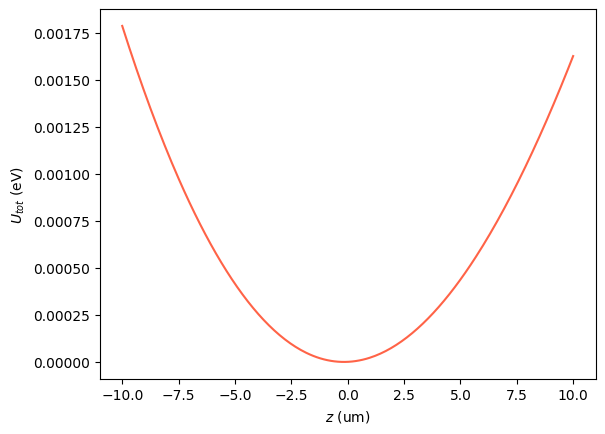

In [28]:
plt.figure()
#zeta0 = np.expand_dims(EquilPos(2, Mj_DC[1:], Mj_RF[1:])[:,-1], axis=1)
zetagrid = np.expand_dims(np.linspace(-10e-6,10e-6,256), axis=1)
shape = np.shape(zetagrid)
all_r = np.concatenate([np.zeros(shape), np.zeros(shape), zetagrid], axis=1)
shape_zeta = np.shape(zeta0)
all_r_zeta = np.concatenate([np.zeros(shape_zeta), np.zeros(shape_zeta), zeta0], axis=1)
#plt.scatter(zetagrid,Phi(zetagrid),s=4,color="midnightblue")
plt.plot(zetagrid.flatten()*1e6,np.array([get_pseudo_pot(r, Mj_RF[1:], rf_scale) for r in all_r]).flatten(),color="tomato")
#plt.scatter(zeta0.flatten()*1e6,np.array([Phi(r, Mj_DC)+get_pseudo_pot(r, Mj_RF[1:], rf_scale)+4e-2 for r in all_r_zeta]).flatten(),color='lightskyblue')
plt.xlabel(r'$z$ (um)')
plt.ylabel(r'$U_{tot}$ (eV)')
plt.show()

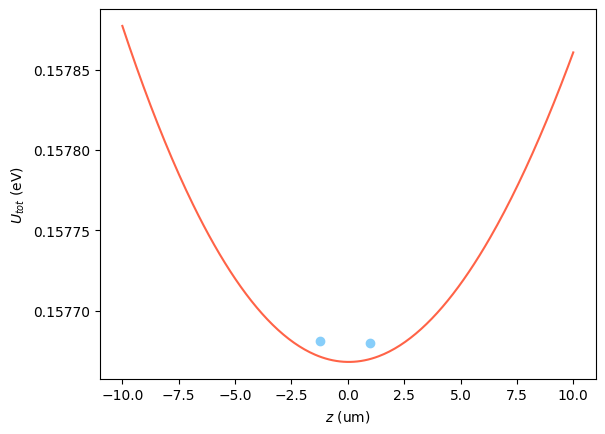

In [29]:
plt.figure()
zeta0 = np.expand_dims(EquilPos(2, Mj_DC[1:], Mj_RF[1:])[:,-1], axis=1)
zetagrid = np.expand_dims(np.linspace(-10e-6,10e-6,256), axis=1)
shape = np.shape(zetagrid)
all_r = np.concatenate([np.zeros(shape), np.zeros(shape), zetagrid], axis=1)
shape_zeta = np.shape(zeta0)
all_r_zeta = np.concatenate([np.zeros(shape_zeta), np.zeros(shape_zeta), zeta0], axis=1)
#plt.scatter(zetagrid,Phi(zetagrid),s=4,color="midnightblue")
plt.plot(zetagrid.flatten()*1e6,np.array([-Phi(r, Mj_DC) for r in all_r]).flatten(),color="tomato")
plt.scatter(zeta0.flatten()*1e6,np.array([-Phi(r, Mj_DC)+1e-5 for r in all_r_zeta]).flatten(),color='lightskyblue')
plt.xlabel(r'$z$ (um)')
plt.ylabel(r'$U_{tot}$ (eV)')
plt.show()

## Motional Frequencies

In [87]:
Mj = util.load_data('spher_harm_coeff')
Mj_DC = Mj['DC0'].flatten()
Mj_RF = Mj['RF0'].flatten()

In [124]:
#### Getting original data ####
x_slice = slice(s.origin[0] - s.roi[0], s.origin[0] + s.roi[0])
y_slice = slice(s.origin[1] - s.roi[1], s.origin[1] + s.roi[1])
z_slice = slice(s.origin[2] - s.roi[2], s.origin[2] + s.roi[2])
p = [35*s.trap.individual_potential_contribution(x = x_slice, y = y_slice, z = z_slice, derivative=i)['RF2'] for i in range(0,4)]

rf_scale_raw = get_rf_scale(l=1e-3, o=2.5e9*2*np.pi)
pseudo_pot_ori = rf_scale_raw**2 * np.array(xr.dot(p[1], p[1], dims = 'l')) # Pseudo potential calculated from original RF field


#### Getting the pseudo/DC potential projection on the x-axis ####
coord_roi = get_potential_data(s, electrode='RF')[0]
X_roi, Y_roi, Z_roi = coord_roi
x, y, z = get_grid(X_roi, Y_roi, Z_roi, position, rotate=True)
x_proj = np.where((z==0) & (y==0))
x_val = x[x_proj]*1e-3 # convert mm to m
pseudo_pot_x0 = pseudo_pot_ori.flatten()[x_proj]

## Reconstructed potential from fitting
zero = np.zeros(np.shape(x_val))
pseudo_pot_x = get_pseudo_pot((x_val, zero, zero), Mj_RF[1:], rf_scale).numpy()
dc_pot_x = Phi((x_val, zero, zero), Mj=Mj_DC)


#### Getting the pseudo/DC potential projection on the z-axis ####
coord_roi, coord, V_roi, V = get_potential_data(s, electrode='DC')
X_roi, Y_roi, Z_roi = coord_roi
x, y, z = get_grid(X_roi, Y_roi, Z_roi, position, rotate=True)
z_proj = np.where((x==0) & (y==0))
z_val = z[z_proj]*1e-3 # convert mm to m
dc_pot_z0 = V_roi.flatten()[z_proj] # Oringal DC potential in z projection
dc_pot_x0 = V_roi.flatten()[x_proj] # Oringal DC potential in x projection
pseudo_pot_z0 = pseudo_pot_ori.flatten()[z_proj] # Original pseudo potential in z projection

## Reconstructed potential from fitting
zero = np.zeros(np.shape(z_val))
pseudo_pot_z = get_pseudo_pot((zero, zero, z_val), Mj_RF[1:], rf_scale).numpy()
dc_pot_z = Phi((zero, zero, z_val), Mj=Mj_DC)
    

#### Adding bounds for the fitting regions ####
x_size, z_size = 10e-6, 10e-6 # fitting only using 1um size
x_val_i = np.where((x_val > -x_size) & (x_val < x_size))
x_val = x_val[x_val_i]
z_val_i = np.where((z_val > -z_size) & (z_val < z_size))
z_val = z_val[z_val_i]

pseudo_pot_x0 = pseudo_pot_x0[x_val_i]
pseudo_pot_x = pseudo_pot_x[x_val_i]
dc_pot_x = dc_pot_x[x_val_i]
dc_pot_x0 = dc_pot_x0[x_val_i]

dc_pot_z = dc_pot_z[z_val_i]
pseudo_pot_z = pseudo_pot_z[z_val_i]
dc_pot_z0 = dc_pot_z0[z_val_i]
pseudo_pot_z0 = pseudo_pot_z0[z_val_i]


#### Prepare inputs for fitting ####
axis_data = [x_val, z_val]
pa = pseudo_pot_x #- dc_pot_x
pb = -dc_pot_z + pseudo_pot_z
pa0 = pseudo_pot_x0 #- dc_pot_x0
pb0 = -dc_pot_z0 + pseudo_pot_z0
potentials = [pa, pb]
potentials0 = [pa0, pb0]

1.5253661915486278 20.71513740026531


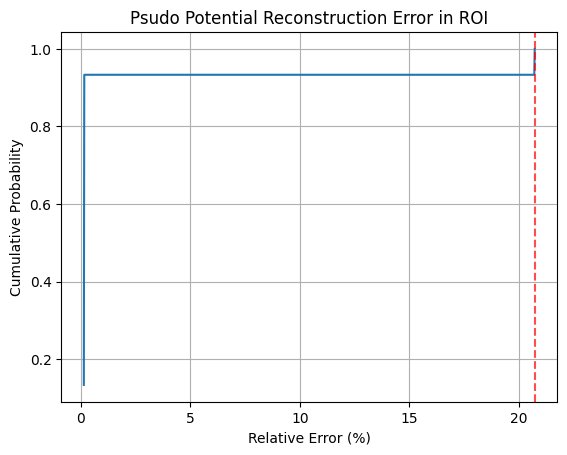

In [125]:
pseudo_roi_err = abs(pseudo_pot_x - pseudo_pot_x0)/pseudo_pot_x0*100
print(np.mean(pseudo_roi_err), max(pseudo_roi_err))
count, bins_count = np.histogram(pseudo_roi_err, bins=1000, weights=np.ones(np.shape(pseudo_roi_err))/len(pseudo_roi_err))
cdf = np.cumsum(count)
plt.plot(bins_count[1:], cdf)
plt.title('Psudo Potential Reconstruction Error in ROI')
plt.xlabel('Relative Error (%)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.axvline(max(pseudo_roi_err), linestyle='--', color='r', alpha=0.7)
plt.show()

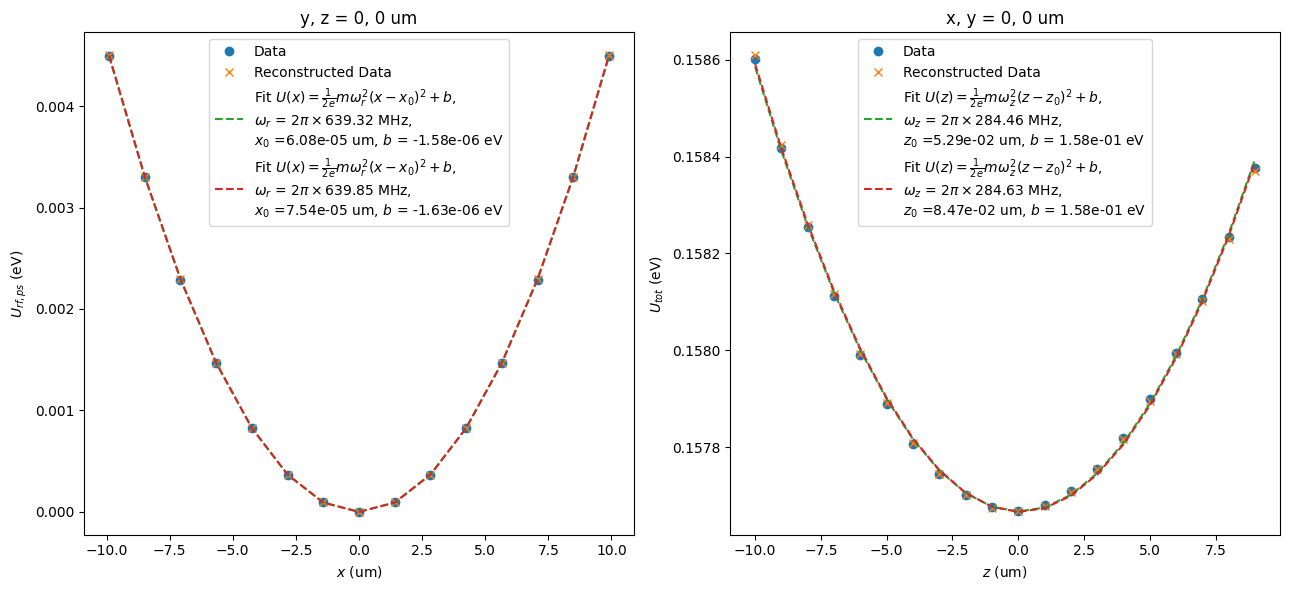

In [126]:
axis = [0,2]
n_points = 100
freq = [2*np.pi*300e6, 2*np.pi*30e6]

rf_scale = get_rf_scale(o=2.5e9*2*np.pi)
fit_func = lambda x, omega, x0, b: 1/2/e*m*(omega**2) * (x-x0)**2 + b

xlabel = [r'$x$ (um)', r'$z$ (um)']
ylabel = [r'$U_{rf, ps}$ (eV)', r'$U_{tot}$ (eV)']

omega_r, omega_z = 0, 0
fig, ax = plt.subplots(figsize=(13,6), ncols=2)
for i in range(2):
    xdata = axis_data[i]
    ydata = potentials[i]
    y0 = potentials0[i]
    
    ax[i].plot(xdata*1e6, y0, 'o', label='Data')
    ax[i].plot(xdata*1e6, ydata, 'x', label='Reconstructed Data')
    init = [freq[i], 0, 0]
    c = curve_fit(fit_func, xdata, ydata, p0=init, xtol=1e-15, ftol=1e-30)[0]
    c1 = curve_fit(fit_func, xdata, y0, p0=init, xtol=1e-15, ftol=1e-30)[0]
    if i == 0:
        ax[i].plot(xdata*1e6, fit_func(xdata, *c1), '--', 
                     label=r'Fit $U(x)=\frac{1}{2e} m\omega_r^2(x-x_0)^2 + b$,' + '\n' +\
                           r'$\omega_r$ = $2\pi\times$'+f'{c1[0]/1e6/2/np.pi:.2f} MHz,' + '\n'+\
                           r'$x_0$' + f' ={c1[1]*1e6:.2e} um'+ \
                           r', $b$' + f' = {c1[2]:.2e} eV')
        ax[i].plot(xdata*1e6, fit_func(xdata, *c), '--', 
                     label=r'Fit $U(x)=\frac{1}{2e} m\omega_r^2(x-x_0)^2 + b$,' + '\n' +\
                           r'$\omega_r$ = $2\pi\times$'+f'{c[0]/1e6/2/np.pi:.2f} MHz,' + '\n'+\
                           r'$x_0$' + f' ={c[1]*1e6:.2e} um'+ \
                           r', $b$' + f' = {c[2]:.2e} eV')
        ax[i].set_title('y, z = 0, 0 um')
        omega_r = c[0]
    else:
        ax[i].plot(xdata*1e6, fit_func(xdata, *c1), '--', 
                     label=r'Fit $U(z)=\frac{1}{2e} m\omega_z^2(z-z_0)^2 + b$,' + '\n' +\
                           r'$\omega_z$ = $2\pi\times$'+f'{c1[0]/1e6/2/np.pi:.2f} MHz,' +'\n'+\
                           r'$z_0$' + f' ={c1[1]*1e6:.2e} um'+ \
                           r', $b$' + f' = {c1[2]:.2e} eV')
        ax[i].plot(xdata*1e6, fit_func(xdata, *c), '--', 
                     label=r'Fit $U(z)=\frac{1}{2e} m\omega_z^2(z-z_0)^2 + b$,' + '\n' +\
                           r'$\omega_z$ = $2\pi\times$'+f'{c[0]/1e6/2/np.pi:.2f} MHz,' +'\n'+\
                           r'$z_0$' + f' ={c[1]*1e6:.2e} um'+ \
                           r', $b$' + f' = {c[2]:.2e} eV')
        ax[i].set_title('x, y = 0, 0 um')
        omega_z = c[0]
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel(ylabel[i])
plt.tight_layout()
ax[0].legend()
ax[1].legend()
plt.show()

In [37]:
omega_rf = 2.5e9 * 2 * np.pi
q = 2*np.sqrt(2)* omega_r / (omega_rf)
a = (omega_z*2/omega_rf)**2

In [ ]:
q, a, a/q

## Testing Fitting with Field

In [143]:
a = np.random.random((3, 100, 25))
a = np.reshape(a, (300,25)) # would need to reshape (3, N, l) into (3N, l)
y_a = np.random.random((300, 1))
Mj=np.linalg.lstsq(a,y_a,rcond=None)

## Adjusting Voltages

In [ ]:
omega_r1 = 468e6 *2*np.pi
omega_z1 = 3/20*468e6*2*np.pi
omega_rf = 2.5e9*2*np.pi
q = 2*np.sqrt(2)* omega_r1 / (omega_rf)
a = (omega_z1*2/omega_rf)**2
print(q, a, omega_r1/2/np.pi/1e6, omega_z1/2/np.pi/1e6)
(omega_r1/omega_r)**2, (omega_z1/omega_z)**2

In [ ]:
def fit_omega_z(factor):
    ydata = -dc_pot_z*factor + 0.78*pseudo_pot_z
    init = [30e6, 0, 0]
    xdata = axis_data[i]
    return curve_fit(fit_func, xdata, ydata, p0=init, xtol=1e-15, ftol=1e-15)[0][0]/2/np.pi/1e6

In [ ]:
from scipy.optimize import minimize

In [ ]:
factors = np.linspace(0, 1.4, 100)
omega_z_fit = [fit_omega_z(i) for i in factors]
plt.plot(factors, omega_z_fit)

In [ ]:
adjusted_potentials = [pseudo_pot_x*0.78, (-dc_pot_z*0.5 + 0.78*pseudo_pot_z)]
axis = [0,2]
n_points = 100
freq = [2*np.pi*300e6, 2*np.pi*30e6]

rf_scale = get_rf_scale(o=2.5e9*2*np.pi)
fit_func = lambda x, omega, x0, b: 1/2/e*m*(omega**2) * (x-x0)**2 + b

xlabel = [r'$x$ (um)', r'$z$ (um)']
ylabel = [r'$U_{rf, ps}$ (eV)', r'$U_{dc}$ (eV)']
fig, ax = plt.subplots(figsize=(13,6), ncols=2)
for i in range(2):
    xdata = axis_data[i]
    ydata = adjusted_potentials[i]
    ax[i].plot(xdata*1e6, ydata, 'o', label='Data')
    init = [freq[i], 0, 0]
    c = curve_fit(fit_func, xdata, ydata, p0=init, xtol=1e-15, ftol=1e-30)[0]
    if i == 0:
        ax[i].plot(xdata*1e6, fit_func(xdata, *c), '--', 
                     label=r'Fit $U(x)=\frac{1}{2e} m\omega_r^2(x-x_0)^2 + b$,' + '\n' +\
                           r'$\omega_r$ = $2\pi\times$'+f'{c[0]/1e6/2/np.pi:.2f} MHz,' + '\n'+\
                           r'$x_0$' + f' ={c[1]*1e6:.2e} um'+ \
                           r', $b$' + f' = {c[2]:.2e} eV')
    else:
        ax[i].plot(xdata*1e6, fit_func(xdata, *c), '--', 
                     label=r'Fit $U(z)=\frac{1}{2e} m\omega_z^2(z-z_0)^2 + b$,' + '\n' +\
                           r'$\omega_z$ = $2\pi\times$'+f'{c[0]/1e6/2/np.pi:.2f} MHz,' +'\n'+\
                           r'$z_0$' + f' ={c[1]*1e6:.2e} um'+ \
                           r', $b$' + f' = {c[2]:.2e} eV')
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel(ylabel[i])
plt.tight_layout()
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
EquilPos(1, Mj_DC[1:]*0.06/0.78, Mj_RF[1:]*0.78, o=2*np.pi*2.5e9)

In [ ]:
EquilPos(2, Mj_DC[1:]*0.06/0.78, Mj_RF[1:]*0.78, o=2*np.pi*2.5e9)

In [ ]:
plt.figure()
zeta0 = np.expand_dims(EquilPos(2, Mj_DC[1:], Mj_RF[1:])[:,-1], axis=1)
zetagrid = np.expand_dims(np.linspace(-10e-6,10e-6,256), axis=1)
shape = np.shape(zetagrid)
all_r = np.concatenate([np.zeros(shape), np.zeros(shape), zetagrid], axis=1)
shape_zeta = np.shape(zeta0)
all_r_zeta = np.concatenate([np.zeros(shape_zeta), np.zeros(shape_zeta), zeta0], axis=1)
#plt.scatter(zetagrid,Phi(zetagrid),s=4,color="midnightblue")
plt.plot(zetagrid.flatten()*1e6,np.array([-Phi(r, Mj_DC) for r in all_r]).flatten(),color="tomato")
plt.scatter(zeta0.flatten()*1e6,np.array([-Phi(r, Mj_DC)+1e-5 for r in all_r_zeta]).flatten(),color='lightskyblue')
plt.xlabel(r'$z$ (um)')
plt.ylabel(r'$U_{tot}$ (eV)')
plt.show()